In [22]:
#library(zoo)
library(glue)
library(dplyr)
#library(rstan)
library(tidyr)
library(ggplot2)
#library(ggrepel)
library(ggthemes)
library(lubridate)
library(tidyverse)
#library(flexdashboard)
library(futile.logger)

# load code from other files in this package
source("globals.R")

In [23]:
library(tidyverse)
library(lubridate)

start_date <- as.Date("2021-6-14")
end_date <- Sys.Date()

full_int <- interval(start_date, end_date)

month_seq = seq(start_date, end_date, by = "month")
month_int = interval(floor_date(month_seq, "month"), ceiling_date(month_seq, "month") - days(1))

data.frame(interval = intersect(full_int, month_int)) %>%
  mutate(start = int_start(interval),
         end = int_end(interval),
         month = month.abb[month(start)],
         year = year(start)) %>%
  select(-interval)

start,end,month,year
<dttm>,<dttm>,<chr>,<dbl>
2021-06-14,2021-06-30,Jun,2021
2021-07-01,2021-07-31,Jul,2021
2021-08-01,2021-08-31,Aug,2021
2021-09-01,2021-09-30,Sep,2021
2021-10-01,2021-10-31,Oct,2021
2021-11-01,2021-11-30,Nov,2021


In [27]:
df <- data.frame(date=seq(start_date, end_date, 1))
df <- df %>%
  mutate(wd=weekdays(date)) %>%
  filter(wd %in% c("Monday", "Tuesday", "Wednesday", "Friday", "Saturday")) %>%
  mutate(Amit=1) %>%
  mutate(Nidhi=ifelse(wd %in% c("Monday", "Wednesday", "Friday"), 1, 0)) %>%
  select(-wd) %>%
  arrange(desc(date))
write_csv(df, "exercise_dates.csv")
df

date,Amit,Nidhi
<date>,<dbl>,<dbl>
2021-12-10,1,1
2021-12-08,1,1
2021-12-07,1,0
2021-12-06,1,1
2021-12-04,1,0
2021-12-03,1,1
2021-12-01,1,1
2021-11-30,1,0
2021-11-29,1,1


In [32]:
df_bw <- read_csv("https://raw.githubusercontent.com/aarora79/biomettracker/master/data/Nidhi.csv") %>%
  mutate(Date=ymd(Date), Weight=as.numeric(Weight))
head(df_bw)
df_deadlifts <- read_csv("https://raw.githubusercontent.com/aarora79/biomettracker/master/raw_data/Amit_deadlifts.csv") %>%
  mutate(date=ymd(date))
head(df_deadlifts)
df_trips <- read_csv("https://raw.githubusercontent.com/aarora79/biomettracker/master/raw_data/trips.csv") %>%
  mutate(startdate=ymd(startdate), enddate=ymd(enddate))
head(df_trips)


── Column specification ────────────────────────────────────────────────────────
cols(
  Date = col_character(),
  Weight = col_character(),
  BMI = col_character(),
  `Body Fat` = col_character(),
  `Lean Mass` = col_character(),
  `Muscle Percentage` = col_character(),
  `Water Percentage` = col_character()
)


Warning message:
“ 3 failed to parse.”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Date,Weight,BMI,Body Fat,Lean Mass,Muscle Percentage,Water Percentage
<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
2021-10-09,133.82,24.6,28.3,95.95,32.8,52.4
2021-10-08,136.47,25.1,28.8,97.16,32.7,51.9
2021-10-07,141.32,26.0,29.9,99.06,32.4,51.1
2021-10-06,138.89,25.6,29.4,98.06,32.5,51.6
2021-10-05,139.55,25.7,29.5,98.38,32.5,51.4
2021-10-04,139.11,25.6,29.4,98.21,32.5,51.5



── Column specification ────────────────────────────────────────────────────────
cols(
  date = col_character(),
  excercise = col_character(),
  set = col_double(),
  reps = col_double(),
  weight = col_double()
)




date,excercise,set,reps,weight
<date>,<chr>,<dbl>,<dbl>,<dbl>
2021-10-06,deadlift,1,5,235
2021-10-06,deadlift,2,5,245
2021-10-06,deadlift,3,5,265
2021-10-06,deadlift,4,3,285
2021-10-06,deadlift,4,3,305
2021-10-06,deadlift,4,2,315



── Column specification ────────────────────────────────────────────────────────
cols(
  trip = col_character(),
  startdate = col_character(),
  enddate = col_character()
)




trip,startdate,enddate
<chr>,<date>,<date>
kalhari waterpark,2021-10-01,2021-10-03
summer ocean getaway to myrtle beach and hilton head,2021-08-13,2021-08-20
smoky mountains,2021-07-02,2021-07-05
new jersey trip for Nidhi's birthday,2021-04-24,2021-04-25


In [3]:
df_trips_tidy <- df_trips %>%
  group_by(trip) %>%
  complete(trip, startdate = seq.Date(min(startdate)-5, max(enddate)+10, by = "day"))  %>%
  rename(date=startdate) %>%
  select(-enddate) %>%
  left_join(df_trips, by="trip") %>%
  mutate(category = case_when(
      date < startdate ~ "pretrip",
      date > enddate ~ "posttrip",
      TRUE ~ "trip"
    )) %>%
  select(-startdate, -enddate)    

df_trips_tidy

trip,date,category
<chr>,<date>,<chr>
kalhari waterpark,2021-09-26,pretrip
kalhari waterpark,2021-09-27,pretrip
kalhari waterpark,2021-09-28,pretrip
kalhari waterpark,2021-09-29,pretrip
kalhari waterpark,2021-09-30,pretrip
kalhari waterpark,2021-10-01,trip
kalhari waterpark,2021-10-02,trip
kalhari waterpark,2021-10-03,trip
kalhari waterpark,2021-10-04,posttrip


In [4]:
df_wt_and_trips <- df_trips_tidy %>%
  left_join(df_bw, by=c("date"="Date")) %>%
  group_by(trip) %>%
  mutate(ip.value=approx(date,Weight,date)$y) %>%
  mutate(Weight = ifelse(is.na(Weight), ip.value, Weight)) %>%
  select(-ip.value)

head(df_wt_and_trips)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


trip,date,category,Weight,BMI,Body Fat,Lean Mass,Muscle Percentage,Water Percentage
<chr>,<date>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
kalhari waterpark,2021-09-26,pretrip,190.26,28.8,27.3,138.32,39.1,53.1
kalhari waterpark,2021-09-27,pretrip,189.82,28.8,27.2,138.19,39.1,53.1
kalhari waterpark,2021-09-28,pretrip,190.26,28.8,27.3,138.32,39.1,53.1
kalhari waterpark,2021-09-29,pretrip,189.60,28.7,27.2,138.03,39.1,53.2
kalhari waterpark,2021-09-30,pretrip,186.51,28.3,26.6,136.9,39.4,53.6
kalhari waterpark,2021-10-01,trip,186.29,28.2,26.6,136.74,39.4,53.6


In [5]:
write_csv(df_wt_and_trips, "wt_and_Trips.csv")

In [6]:
df_wt_and_trips %>%
  group_by(trip) %>%
  mutate(ip.value=approx(date,Weight,date)$y) %>%
  mutate(Weight = ifelse(is.na(Weight), ip.value, Weight)) %>%
  select(-ip.value)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


trip,date,category,Weight,BMI,Body Fat,Lean Mass,Muscle Percentage,Water Percentage
<chr>,<date>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
kalhari waterpark,2021-09-26,pretrip,190.2600,28.8,27.3,138.32,39.1,53.1
kalhari waterpark,2021-09-27,pretrip,189.8200,28.8,27.2,138.19,39.1,53.1
kalhari waterpark,2021-09-28,pretrip,190.2600,28.8,27.3,138.32,39.1,53.1
kalhari waterpark,2021-09-29,pretrip,189.6000,28.7,27.2,138.03,39.1,53.2
kalhari waterpark,2021-09-30,pretrip,186.5100,28.3,26.6,136.9,39.4,53.6
kalhari waterpark,2021-10-01,trip,186.2900,28.2,26.6,136.74,39.4,53.6
kalhari waterpark,2021-10-02,trip,187.1175,NA,NA,NA,NA,NA
kalhari waterpark,2021-10-03,trip,187.9450,NA,NA,NA,NA,NA
kalhari waterpark,2021-10-04,posttrip,188.7725,NA,NA,NA,NA,NA


In [7]:
df_wt_gain <- df_wt_and_trips %>%
  left_join(df_trips, by="trip") %>%
  filter(date >= startdate & date <= (enddate+1)) %>%
  group_by(trip) %>%
  summarize(wt_gain = max(Weight)-min(Weight))
df_wt_gain

trip,wt_gain
<chr>,<dbl>
kalhari waterpark,2.4825
new jersey trip for Nidhi's birthday,7.2700
smoky mountains,3.0800
summer ocean getaway to myrtle beach and hilton head,7.9400


Warning message:
“Removed 4 rows containing missing values (geom_point).”


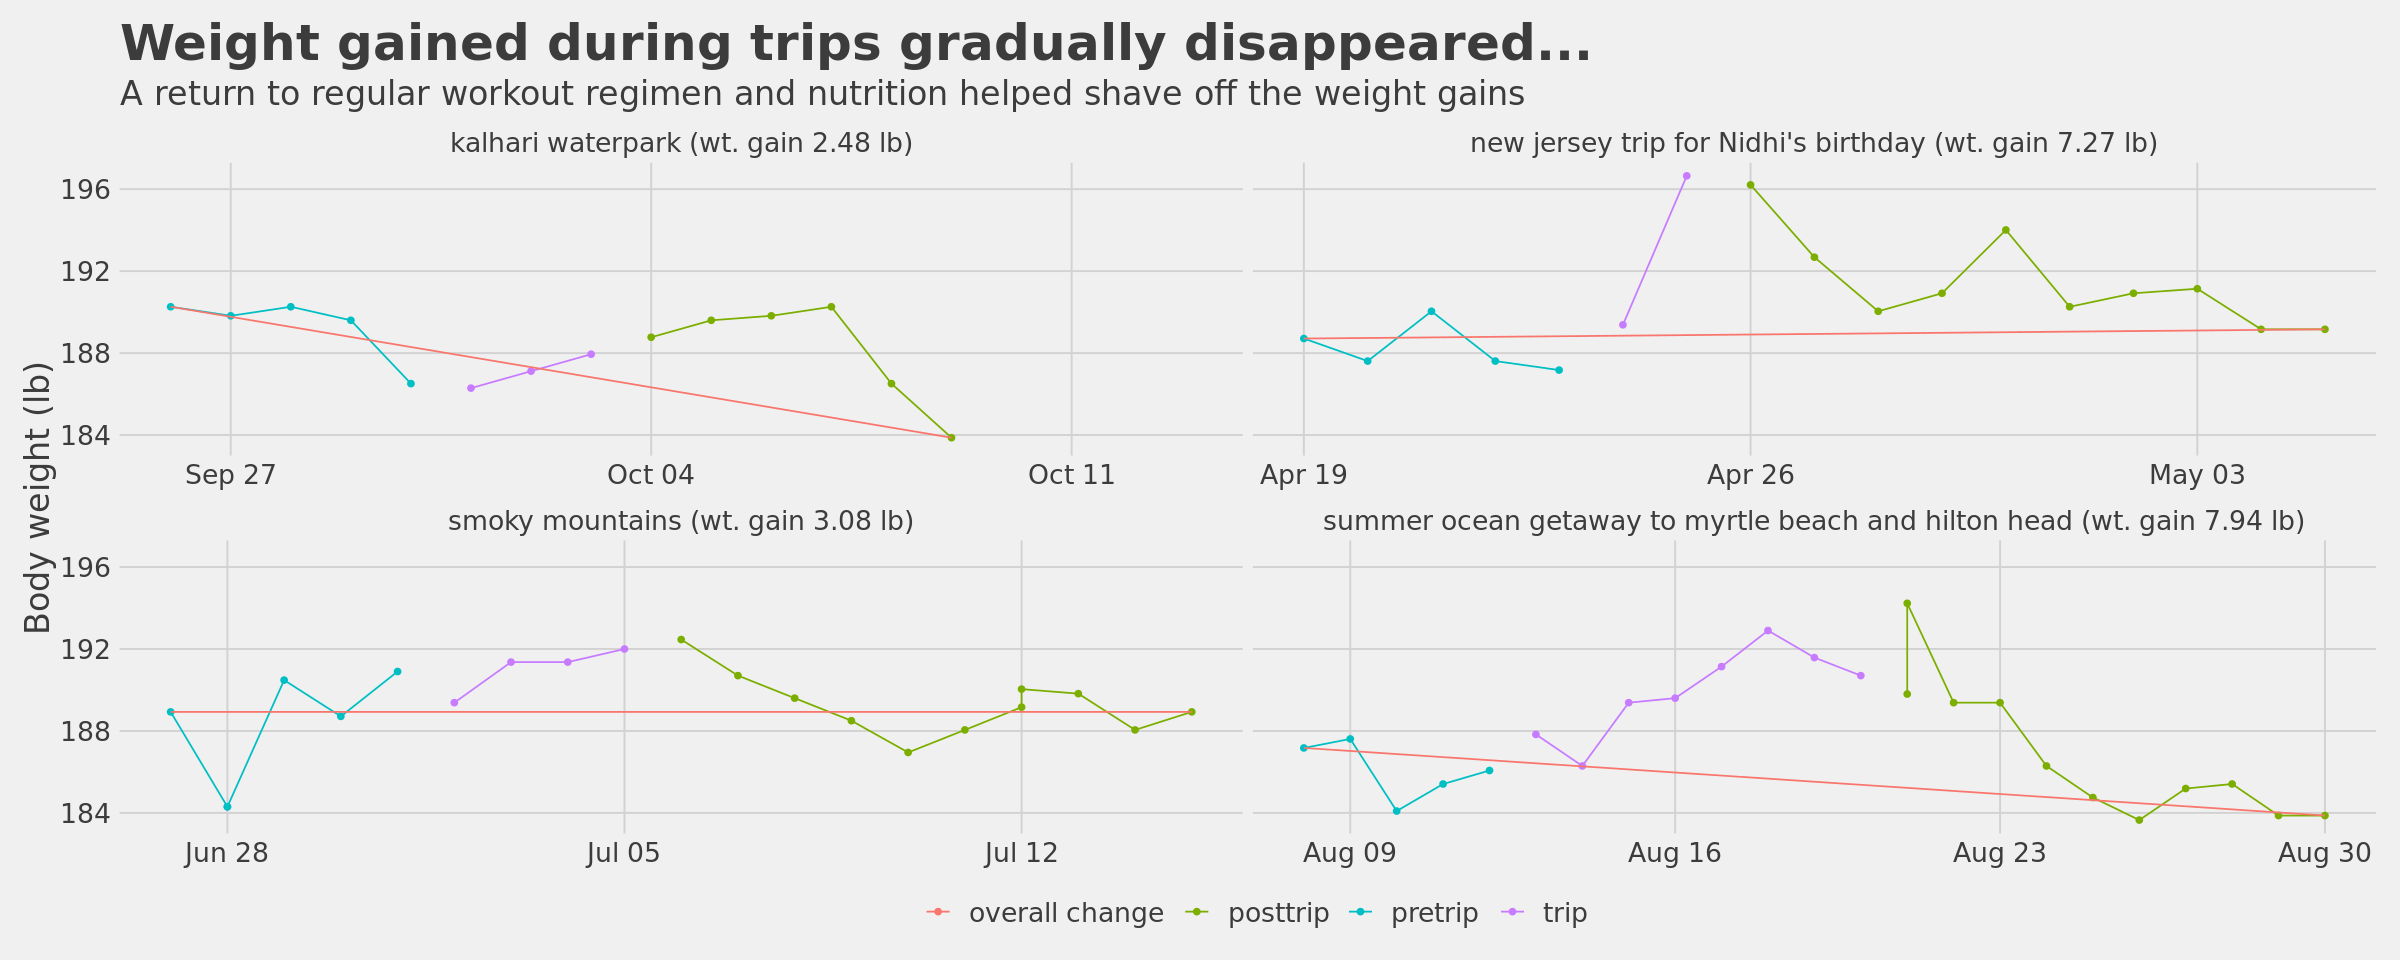

In [32]:
options(repr.plot.width=20, repr.plot.height=8)

title <- "Regular workouts bring bodyweight back to pre-vacation level"
title <- "Weight gained during trips gradually disappeared..."
subtitle <- "Feeling guilty about vacation weight gain and crash dieting does not help and is not needed!"
subtitle <- "A return to regular workout regimen and nutrition helped shave off the weight gains"
df_wt_and_trips_more <- df_wt_and_trips %>%
  left_join(df_wt_gain, by="trip") %>%
  mutate(trip = glue("{trip} (wt. gain {round(wt_gain, 2)} lb)")) %>%
  mutate(trip = fct_reorder(trip, Weight, min)) %>%
  arrange(trip)

df_before_and_after <- df_wt_and_trips_more %>%
  filter(!is.na(Weight)) %>%
  filter(date == min(date) | date == max(date)) %>%
  select(trip, date, Weight) %>%
  mutate(category = "overall change")


df_wt_and_trips_more %>%
  #mutate(group = ifelse(date==min(date) | date==max(date), "paired", "not-paired")) %>%
  ggplot(aes(x=date, y=Weight, col=category)) +
  geom_point() + 
  geom_line() +
  geom_line(data=df_before_and_after, aes(x=date, y=Weight), show.legend = FALSE) +
  #geom_line(aes(group = group), color=I("black")) +
  facet_wrap(~trip, scale="free_x") +
  theme_fivethirtyeight() + 
  labs(title=title,
       subtitle=subtitle) +
  theme(legend.position="bottom", legend.title = element_blank()) +
  theme(axis.title = element_text(), axis.title.x = element_blank(), text = element_text(size=20)) + 
  xlab("") +
  ylab('Body weight (lb)')

trip,date,Weight,category
<fct>,<date>,<dbl>,<chr>
kalhari waterpark (wt. gain during trip2.48 lb),2021-09-26,190.26,overall change
kalhari waterpark (wt. gain during trip2.48 lb),2021-10-09,183.87,overall change
new jersey trip for Nidhi's birthday (wt. gain during trip7.27 lb),2021-04-19,188.71,overall change
new jersey trip for Nidhi's birthday (wt. gain during trip7.27 lb),2021-05-05,189.16,overall change
smoky mountains (wt. gain during trip3.08 lb),2021-06-27,188.93,overall change
smoky mountains (wt. gain during trip3.08 lb),2021-07-15,188.93,overall change
summer ocean getaway to myrtle beach and hilton head (wt. gain during trip7.94 lb),2021-08-08,187.17,overall change
summer ocean getaway to myrtle beach and hilton head (wt. gain during trip7.94 lb),2021-08-30,183.87,overall change


In [9]:
df_wt_and_trips %>%
  left_join(df_wt_gain, by="trip") %>%
  mutate(trip = glue("{trip} (wt. gain {round(wt_gain, 2)} lb)")) %>%
  mutate(trip = fct_reorder(trip, date)) %>%
  arrange(desc(trip))

trip,date,category,Weight,BMI,Body Fat,Lean Mass,Muscle Percentage,Water Percentage,wt_gain
<fct>,<date>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
summer ocean getaway to myrtle beach and hilton head (wt. gain 7.94 lb),2021-08-08,pretrip,187.17,28.4,26.7,137.2,39.3,53.5,7.94
summer ocean getaway to myrtle beach and hilton head (wt. gain 7.94 lb),2021-08-09,pretrip,187.61,28.4,26.8,137.33,39.3,53.4,7.94
summer ocean getaway to myrtle beach and hilton head (wt. gain 7.94 lb),2021-08-10,pretrip,184.09,27.9,26.1,136.04,39.6,53.9,7.94
summer ocean getaway to myrtle beach and hilton head (wt. gain 7.94 lb),2021-08-11,pretrip,185.41,28.1,26.4,136.46,39.5,53.7,7.94
summer ocean getaway to myrtle beach and hilton head (wt. gain 7.94 lb),2021-08-12,pretrip,186.07,28.2,26.5,136.76,39.4,53.7,7.94
summer ocean getaway to myrtle beach and hilton head (wt. gain 7.94 lb),2021-08-13,trip,187.83,28.5,26.9,137.31,39.3,53.4,7.94
summer ocean getaway to myrtle beach and hilton head (wt. gain 7.94 lb),2021-08-14,trip,186.29,28.2,26.5,136.92,39.4,53.7,7.94
summer ocean getaway to myrtle beach and hilton head (wt. gain 7.94 lb),2021-08-15,trip,189.38,28.7,27.1,138.06,39.2,53.2,7.94
summer ocean getaway to myrtle beach and hilton head (wt. gain 7.94 lb),2021-08-16,trip,189.60,28.7,27.1,138.22,39.1,53.2,7.94


In [18]:
df_trips %>% group_by(trip) %>% summarize(startdate = min(startdate)) %>% pull(startdate)

[1] "2021-10-01" "2021-04-24" "2021-07-02" "2021-08-13"

In [103]:
# get the max deadlift on a particular data
df_deadlifts_only <- df_deadlifts %>%
  filter(excercise == "deadlift")

head(df_deadlifts_only)

date,excercise,set,reps,weight
<date>,<chr>,<dbl>,<dbl>,<dbl>
2021-09-01,deadlift,1,5,235
2021-09-01,deadlift,2,5,255
2021-09-01,deadlift,3,5,275
2021-09-01,deadlift,4,3,295
2021-09-01,deadlift,4,3,305
2021-09-01,deadlift,4,3,315


In [104]:
df_deadlift_max <- df_deadlifts_only %>%
  group_by(date) %>%
  summarize(weight = max(weight, na.rm=TRUE)) %>%
  arrange(desc(date))

head(df_deadlift_max, 40)

date,weight
<date>,<dbl>
2021-09-01,325
2021-08-25,305
2021-08-18,305
2021-08-04,235
2021-07-28,305
2021-07-21,325
2021-07-14,295
2021-07-07,295
2021-07-01,235


In [105]:
# join with the weight data
df_deadlift_and_bodyweight <- df_deadlift_max %>%
  left_join(df_bw %>% select(Date, Weight) %>% 
            rename(bodyweight=Weight), by=c("date" = "Date")) %>%
  mutate(dl_to_bw_ratio = round(weight/bodyweight, 4))

head(df_deadlift_and_bodyweight, 5)

date,weight,bodyweight,dl_to_bw_ratio
<date>,<dbl>,<dbl>,<dbl>
2021-09-01,325,185.80,1.7492
2021-08-25,305,184.75,1.6509
2021-08-18,305,192.90,1.5811
2021-08-04,235,186.51,1.2600
2021-07-28,305,185.41,1.6450


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



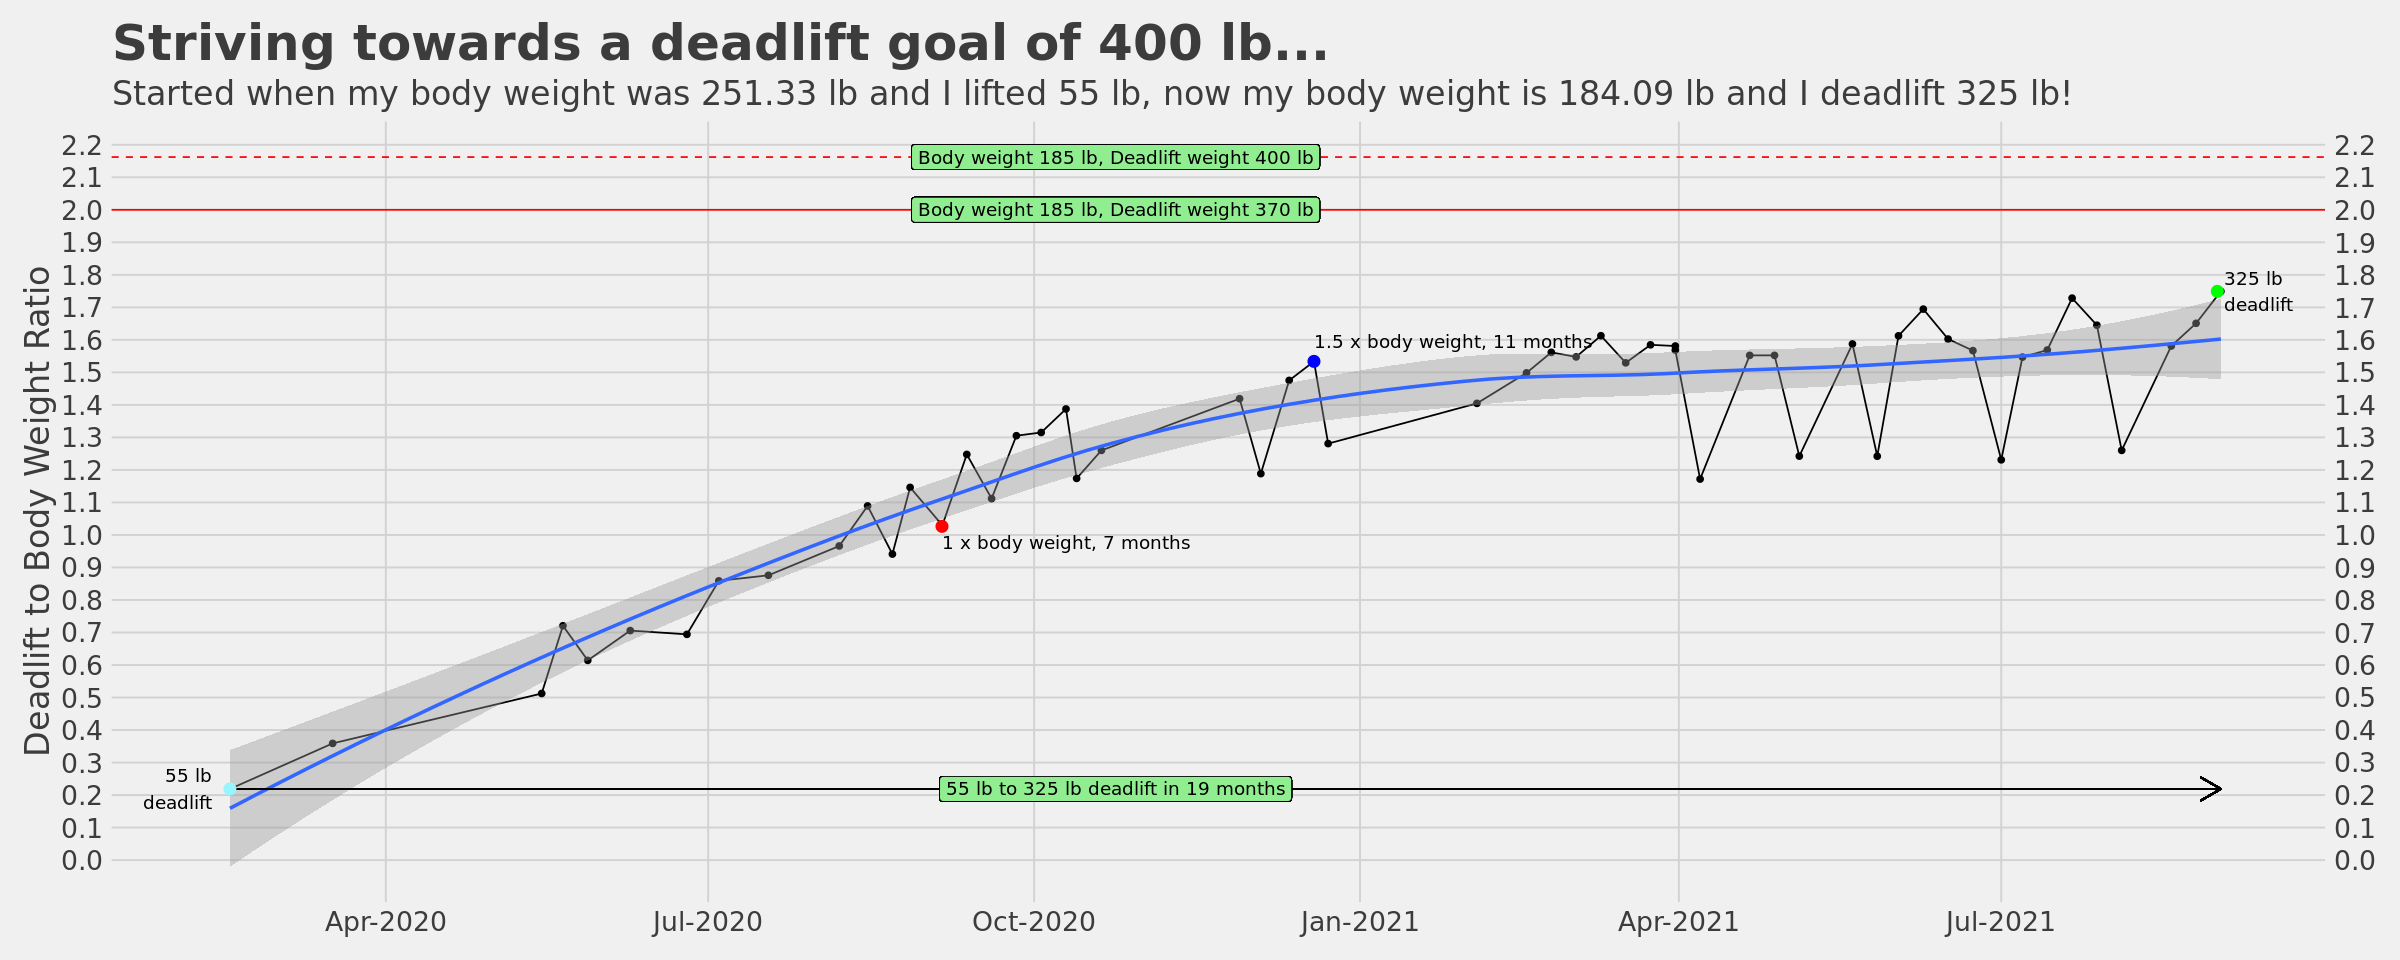

In [106]:
title <- "Striving towards a deadlift goal of 400 lb..."
maxbw <- max(df_deadlift_and_bodyweight$bodyweight)
minbw <- min(df_deadlift_and_bodyweight$bodyweight)

maxdl <- max(df_deadlift_and_bodyweight$weight)
mindl <- min(df_deadlift_and_bodyweight$weight)

subtitle <- glue("Started when my body weight was {maxbw} lb and I lifted {mindl} lb, now my body weight is {minbw} lb and I deadlift {maxdl} lb!")
journey_text <- glue("{min(df_deadlift_and_bodyweight$weight)} lb to {max(df_deadlift_and_bodyweight$weight)} lb deadlift in {ceiling(difftime(max(df_deadlift_and_bodyweight$date), min(df_deadlift_and_bodyweight$date), units='days')/30)} months")

options(repr.plot.width=20, repr.plot.height=8)
RATIO_GOAL <- 2
RATIO_STRETCH_GOAL <- 400/185
two_x_text <- glue("Body weight 185 lb, Deadlift weight 370 lb")
fh_text <- glue("Body weight 185 lb, Deadlift weight 400 lb")

p <- df_deadlift_and_bodyweight %>%
  ggplot(aes(x=date, y=dl_to_bw_ratio)) +
  geom_point() + 
  geom_line() +
  geom_hline(yintercept=RATIO_GOAL, color=I("red")) +
  geom_hline(yintercept=RATIO_STRETCH_GOAL, color=I("red"), linetype="dashed") +
  geom_smooth() +
  geom_segment(aes(x = min(date), y = min(dl_to_bw_ratio), xend = max(date), yend = min(dl_to_bw_ratio)), arrow = arrow(length = unit(0.5, "cm"))) +
  geom_label(aes(x = min(date)+250, y = RATIO_GOAL, label = two_x_text), fill = "lightgreen") +
  geom_label(aes(x = min(date)+250, y = RATIO_STRETCH_GOAL, label = fh_text), fill = "lightgreen") +
  geom_label(aes(x = min(date)+250, y = min(dl_to_bw_ratio), label = journey_text), fill = "lightgreen") +
  scale_y_continuous(breaks=seq(0, 2.5, 0.1), sec.axis = sec_axis(~ . * 1, breaks = seq(0, 2.5, 0.1))) +
  scale_x_date(date_breaks = "3 month", date_labels="%b-%Y") +
  theme_fivethirtyeight() + 
  labs(title=title,
       subtitle=subtitle) +
  theme(legend.position="none") +
  theme(axis.title = element_text(), axis.title.x = element_blank(), text = element_text(size=20)) + 
  xlab("") +
  ylab('Deadlift to Body Weight Ratio')
#p

one_bw_dl <- df_deadlift_and_bodyweight %>%
  filter(between(dl_to_bw_ratio, 1, 1.05)) %>%
  filter(date == min(date) & dl_to_bw_ratio == min(dl_to_bw_ratio))
months_to_one_x_bw_dl <- ceiling(difftime(one_bw_dl$date, min(df_deadlift_and_bodyweight$date), units="days")/30)

one_and_half_bw_dl <- df_deadlift_and_bodyweight %>%
  filter(between(dl_to_bw_ratio, 1.5, 1.55)) %>%
  filter(date == min(date))
months_to_one_and_half_bw_dl <- ceiling(difftime(one_and_half_bw_dl$date, min(df_deadlift_and_bodyweight$date), units="days")/30)

p +  
annotate(geom = "point", x = min(df_deadlift_and_bodyweight$date), y = min(df_deadlift_and_bodyweight$dl_to_bw_ratio), colour = "cadetblue1", size = 3) +
annotate(geom = "point", x = one_bw_dl$date, y = one_bw_dl$dl_to_bw_ratio, colour = "red", size = 3) +
annotate(geom = "text", x = one_bw_dl$date, y = one_bw_dl$dl_to_bw_ratio-0.05, , label = glue("1 x body weight, {months_to_one_x_bw_dl} months"), hjust = "left") +
annotate(geom = "text", x = one_and_half_bw_dl$date, y = one_and_half_bw_dl$dl_to_bw_ratio+0.06, , label = glue("1.5 x body weight, {months_to_one_and_half_bw_dl} months"), hjust = "left") +
annotate(geom = "point", x = one_and_half_bw_dl$date, y = one_and_half_bw_dl$dl_to_bw_ratio, colour = "blue", size = 3) +
annotate(geom = "point", x = max(df_deadlift_and_bodyweight$date)-1, y = max(df_deadlift_and_bodyweight$dl_to_bw_ratio), colour = "green", size = 3) +
annotate(geom = "text", x = max(df_deadlift_and_bodyweight$date)+1, y = max(df_deadlift_and_bodyweight$dl_to_bw_ratio), label = glue("{max(df_deadlift_and_bodyweight$weight)} lb\ndeadlift"), hjust = "left") +
annotate(geom = "text", x = min(df_deadlift_and_bodyweight$date)-5, y = min(df_deadlift_and_bodyweight$dl_to_bw_ratio), label = glue("{min(df_deadlift_and_bodyweight$weight)} lb\ndeadlift"), hjust = "right") 
#+
#annotate(geom = "text", x = min(df_deadlift_and_bodyweight$date)+250, y = min(df_deadlift_and_bodyweight$dl_to_bw_ratio)+0.1, label = journey_text, hjust = "center")




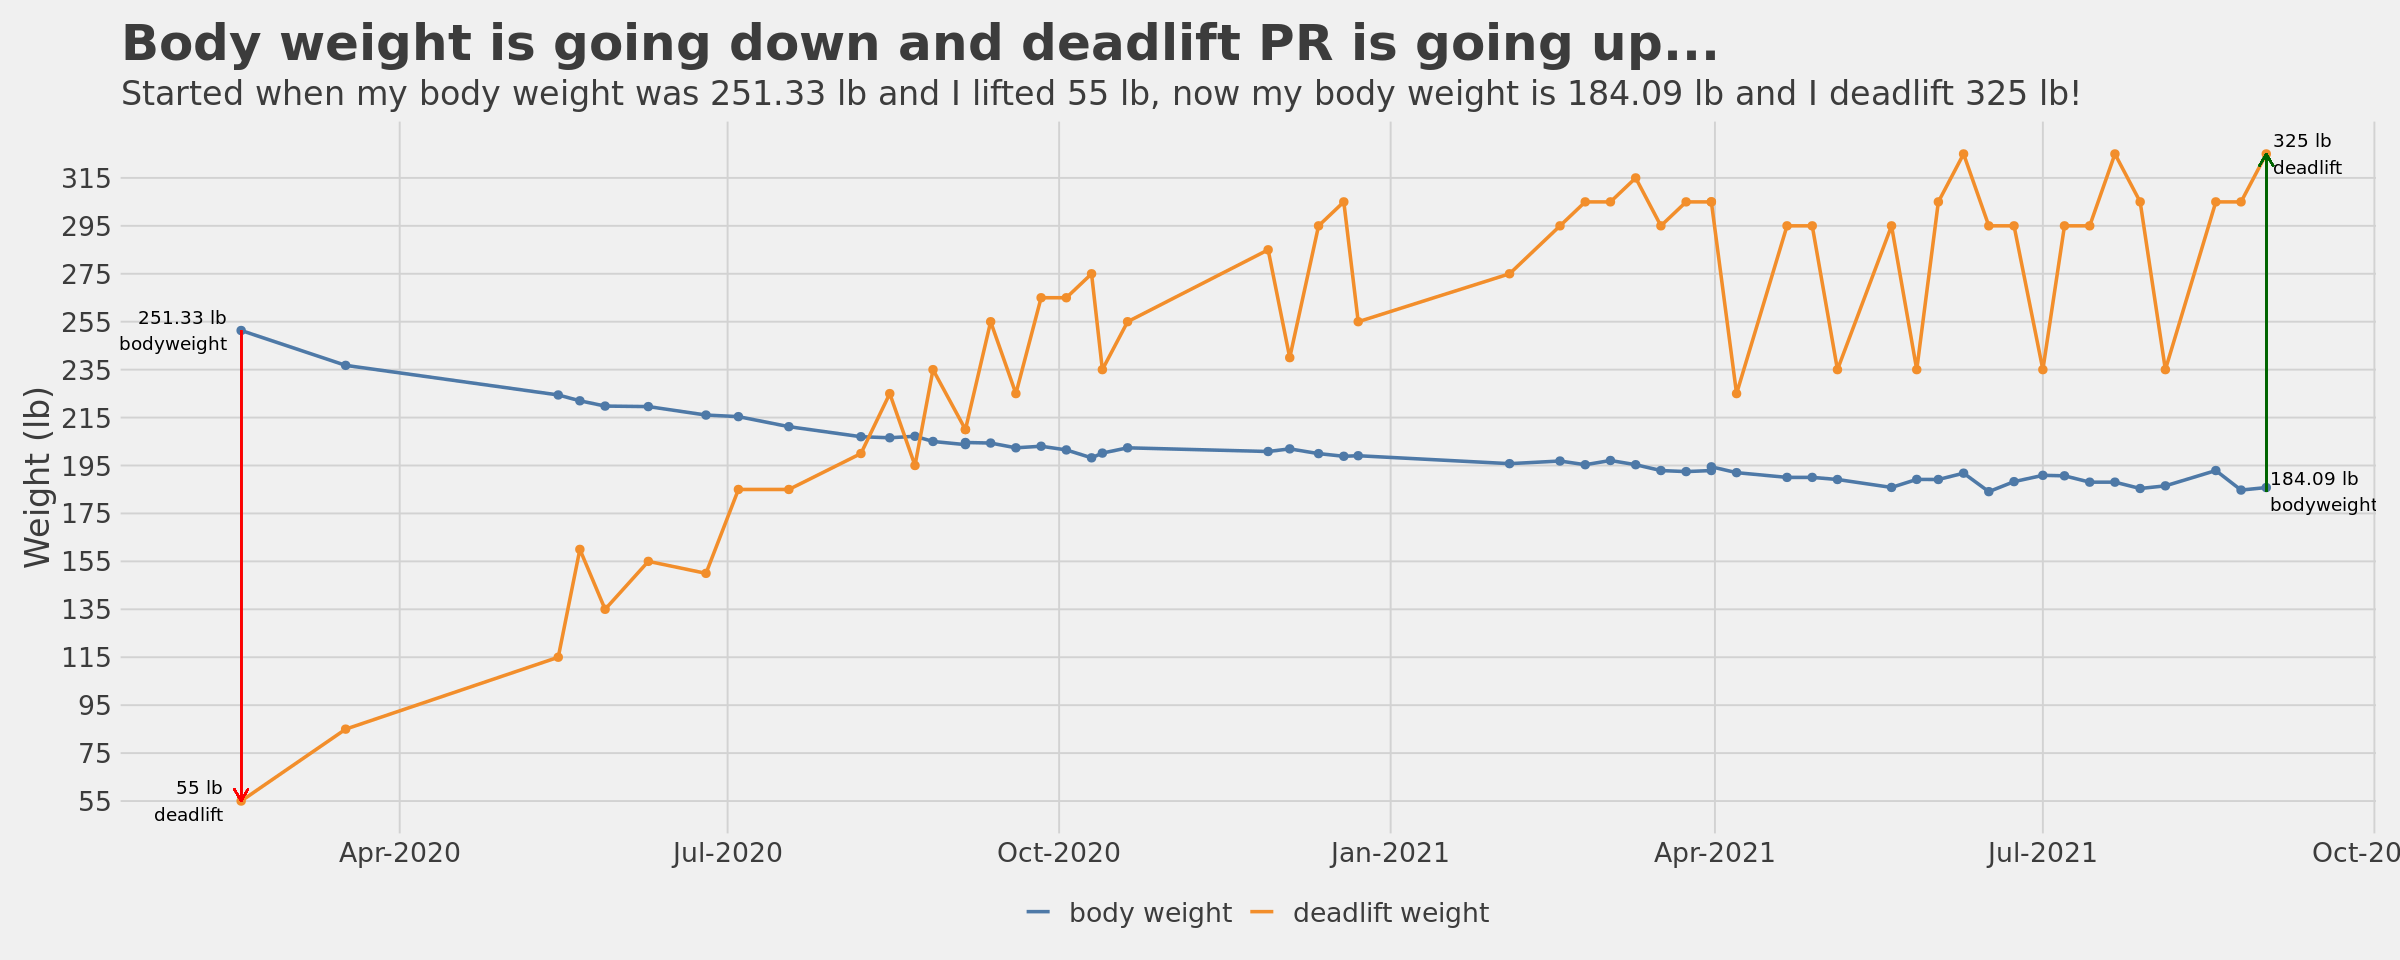

In [107]:
title <- "Body weight is going down and deadlift PR is going up..."
maxbw <- max(df_deadlift_and_bodyweight$bodyweight)
minbw <- min(df_deadlift_and_bodyweight$bodyweight)

maxdl <- max(df_deadlift_and_bodyweight$weight)
mindl <- min(df_deadlift_and_bodyweight$weight)

subtitle <- glue("Started when my body weight was {maxbw} lb and I lifted {mindl} lb, now my body weight is {minbw} lb and I deadlift {maxdl} lb!")

options(repr.plot.width=20, repr.plot.height=8)

df_dl_and_bw_tidy <- df_deadlift_and_bodyweight %>%
  select(-dl_to_bw_ratio) %>%
  rename(`deadlift weight`=weight, `body weight`=bodyweight) %>%
  gather(k, v, -date)

p <- df_dl_and_bw_tidy %>%
  ggplot(aes(x=date, y=v, col=k)) +
  geom_point(size=2, show.legend=FALSE) + 
  geom_line(size=1) +
  scale_y_continuous(breaks=seq(min(df_dl_and_bw_tidy$v), max(df_dl_and_bw_tidy$v), 20)) +
  scale_x_date(date_breaks = "3 month", date_labels="%b-%Y") +
  scale_color_tableau() +
  theme_fivethirtyeight() + 
  geom_segment(aes(xend = min(date), yend = min(df_deadlift_and_bodyweight$weight), x = min(date), y = max(df_deadlift_and_bodyweight$bodyweight)), arrow = arrow(length = unit(0.3, "cm")), color="red") +
  geom_segment(aes(x = max(date), y = min(df_deadlift_and_bodyweight$bodyweight), xend = max(date), yend = max(df_deadlift_and_bodyweight$weight)), arrow = arrow(length = unit(0.3, "cm")), color="darkgreen") +
  labs(title=title,
       subtitle=subtitle) +
  theme(legend.position="bottom", legend.title = element_blank()) +
  theme(axis.title = element_text(), axis.title.x = element_blank(), text = element_text(size=20)) + 
  xlab("") +
  ylab('Weight (lb)')
p +
annotate(geom = "text", x = max(df_deadlift_and_bodyweight$date)+2, y = max(df_deadlift_and_bodyweight$weight), label = glue("{max(df_deadlift_and_bodyweight$weight)} lb\ndeadlift"), hjust = "left") +
annotate(geom = "text", x = min(df_deadlift_and_bodyweight$date)-5, y = min(df_deadlift_and_bodyweight$weight), label = glue("{min(df_deadlift_and_bodyweight$weight)} lb\ndeadlift"), hjust = "right") +
annotate(geom = "text", x = max(df_deadlift_and_bodyweight$date)+1, y = min(df_deadlift_and_bodyweight$bodyweight), label = glue("{min(df_deadlift_and_bodyweight$bodyweight)} lb\nbodyweight"), hjust = "left") +
annotate(geom = "text", x = min(df_deadlift_and_bodyweight$date)-4, y = max(df_deadlift_and_bodyweight$bodyweight), label = glue("{max(df_deadlift_and_bodyweight$bodyweight)} lb\nbodyweight"), hjust = "right") 


In [109]:
install.packages("flexdashboard")

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



In [28]:
df <- read_csv(file.path(RAW_DATA_DIR, "exercise_dates.csv")) %>%
  select(date, Amit) %>%
  mutate(date=ymd(date))

df$week <- cut(as.Date(df$date), "week")
head(df)


── Column specification ────────────────────────────────────────────────────────
cols(
  date = col_character(),
  Amit = col_double(),
  Nidhi = col_double()
)




date,Amit,week
<date>,<dbl>,<fct>
2021-12-10,1,2021-12-06
2021-12-08,1,2021-12-06
2021-12-07,1,2021-12-06
2021-12-06,1,2021-12-06
2021-12-04,1,2021-11-29
2021-12-03,1,2021-11-29


In [29]:
df_workouts_per_week <- df %>%
  arrange(date) %>%
  count(week)

head(df_workouts_per_week)

week,n
<fct>,<int>
2020-01-06,1
2020-01-13,1
2020-01-20,2
2020-01-27,2
2020-02-03,2
2020-02-10,2


In [30]:
df_5_days_a_week <- df_workouts_per_week %>%
  mutate(week=ymd(week)) %>%
  filter(n==5)
max(df_5_days_a_week$week)

[1] "2021-11-29"

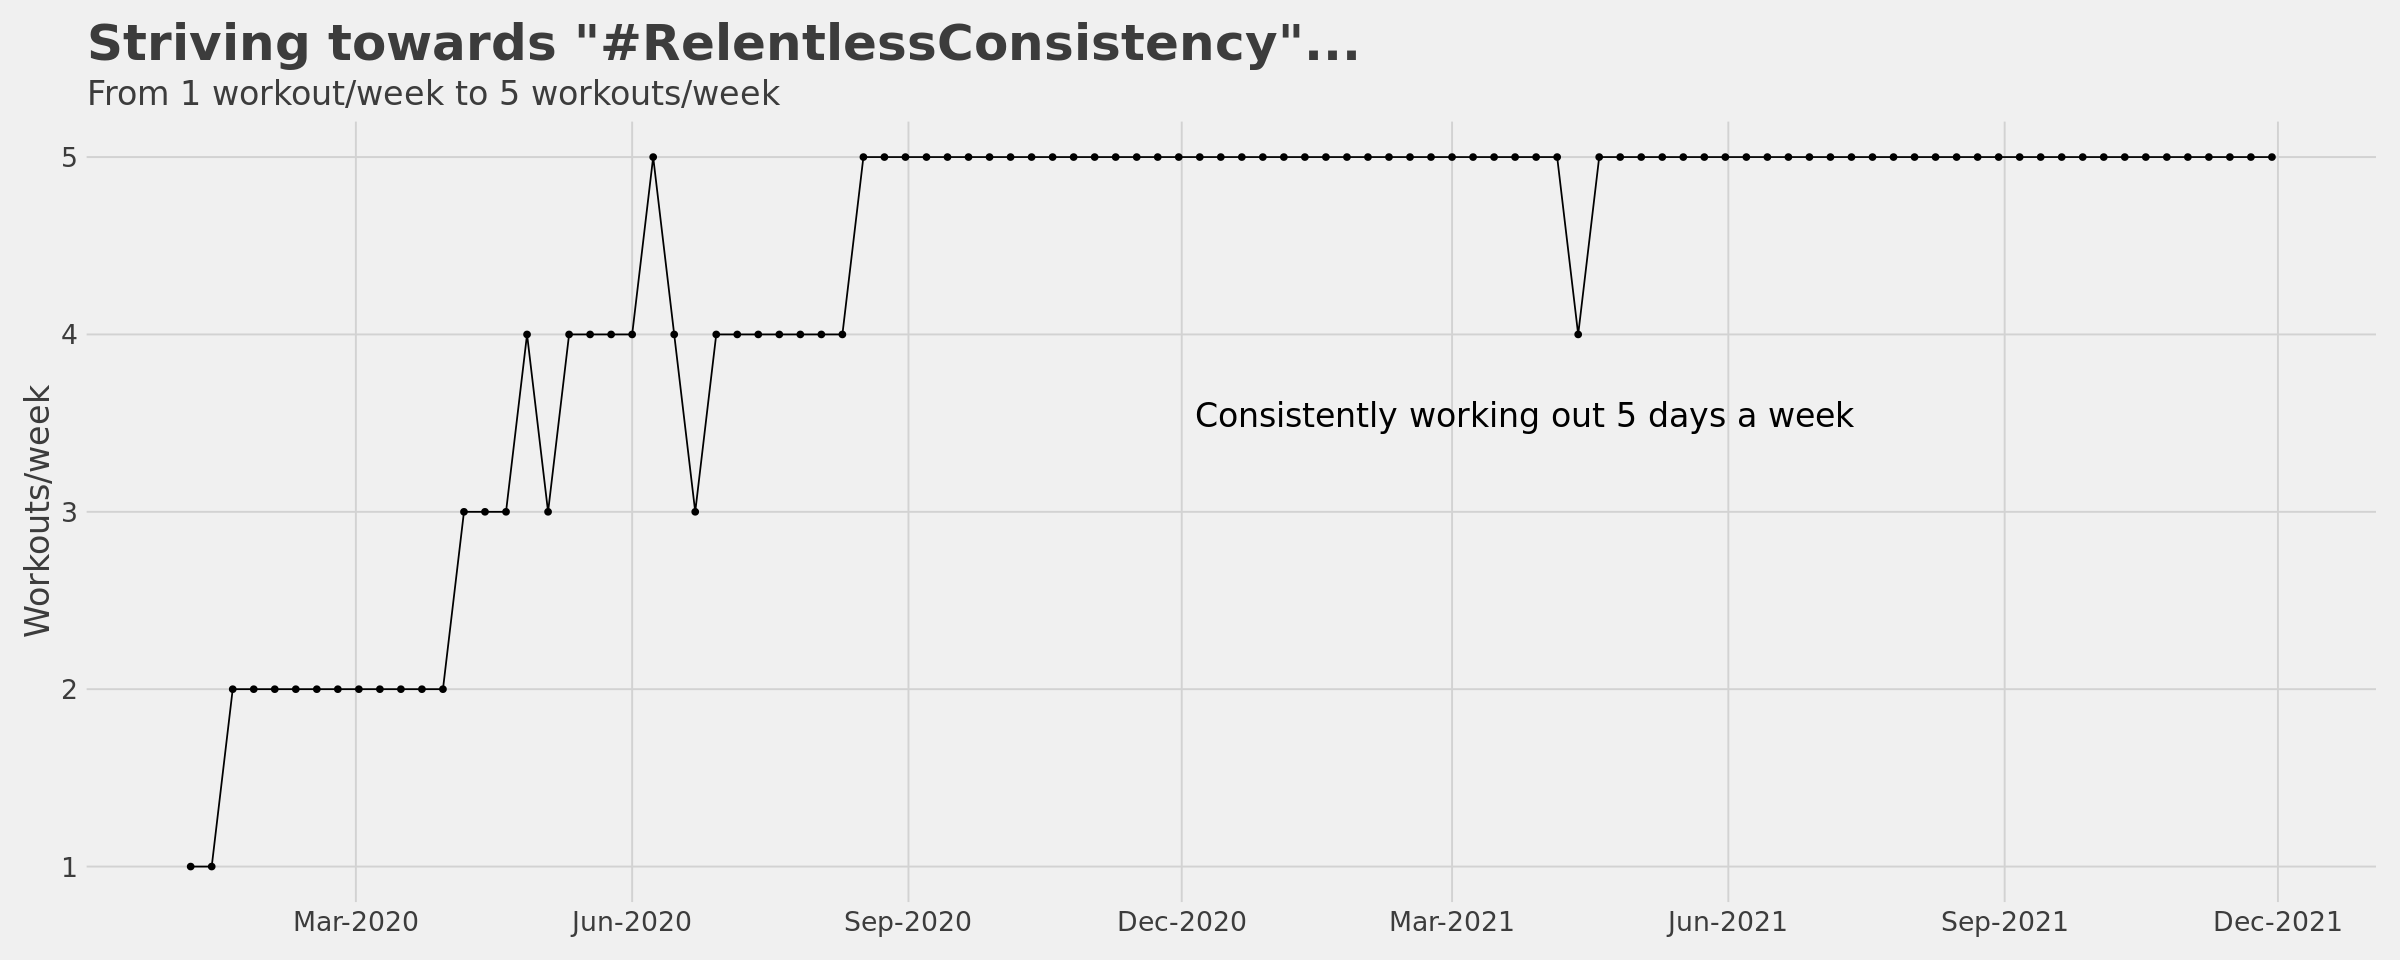

In [44]:
options(repr.plot.width=20, repr.plot.height=8)
df_5_days_a_week <- df_workouts_per_week %>%
  mutate(week=ymd(week)) %>%
  filter(n==5)
title <- "Striving towards \"#RelentlessConsistency\"..."
subtitle <- "From 1 workout/week to 5 workouts/week"
p <- df_workouts_per_week %>%
  filter(ymd(week) != max(ymd(week))) %>%
  ggplot(aes(x=ymd(week), y=n)) +
  geom_point() + 
  geom_line() +
  annotate("text", x=min(df_5_days_a_week$week)+290, y=3.55, label="Consistently working out 5 days a week", size=7) +  
  #geom_smooth("loess") +
  scale_y_continuous(breaks=seq(1,6,1)) +
  scale_x_date(date_breaks = "3 month", date_labels="%b-%Y") +
  theme_fivethirtyeight() + 
  labs(title=title,
       subtitle=subtitle) +
  theme(legend.position="none") +
  theme(axis.title = element_text(), axis.title.x = element_blank(), text = element_text(size=20)) + 
  ylab('Workouts/week')
p

In [45]:
#install.packages("pBrackets")

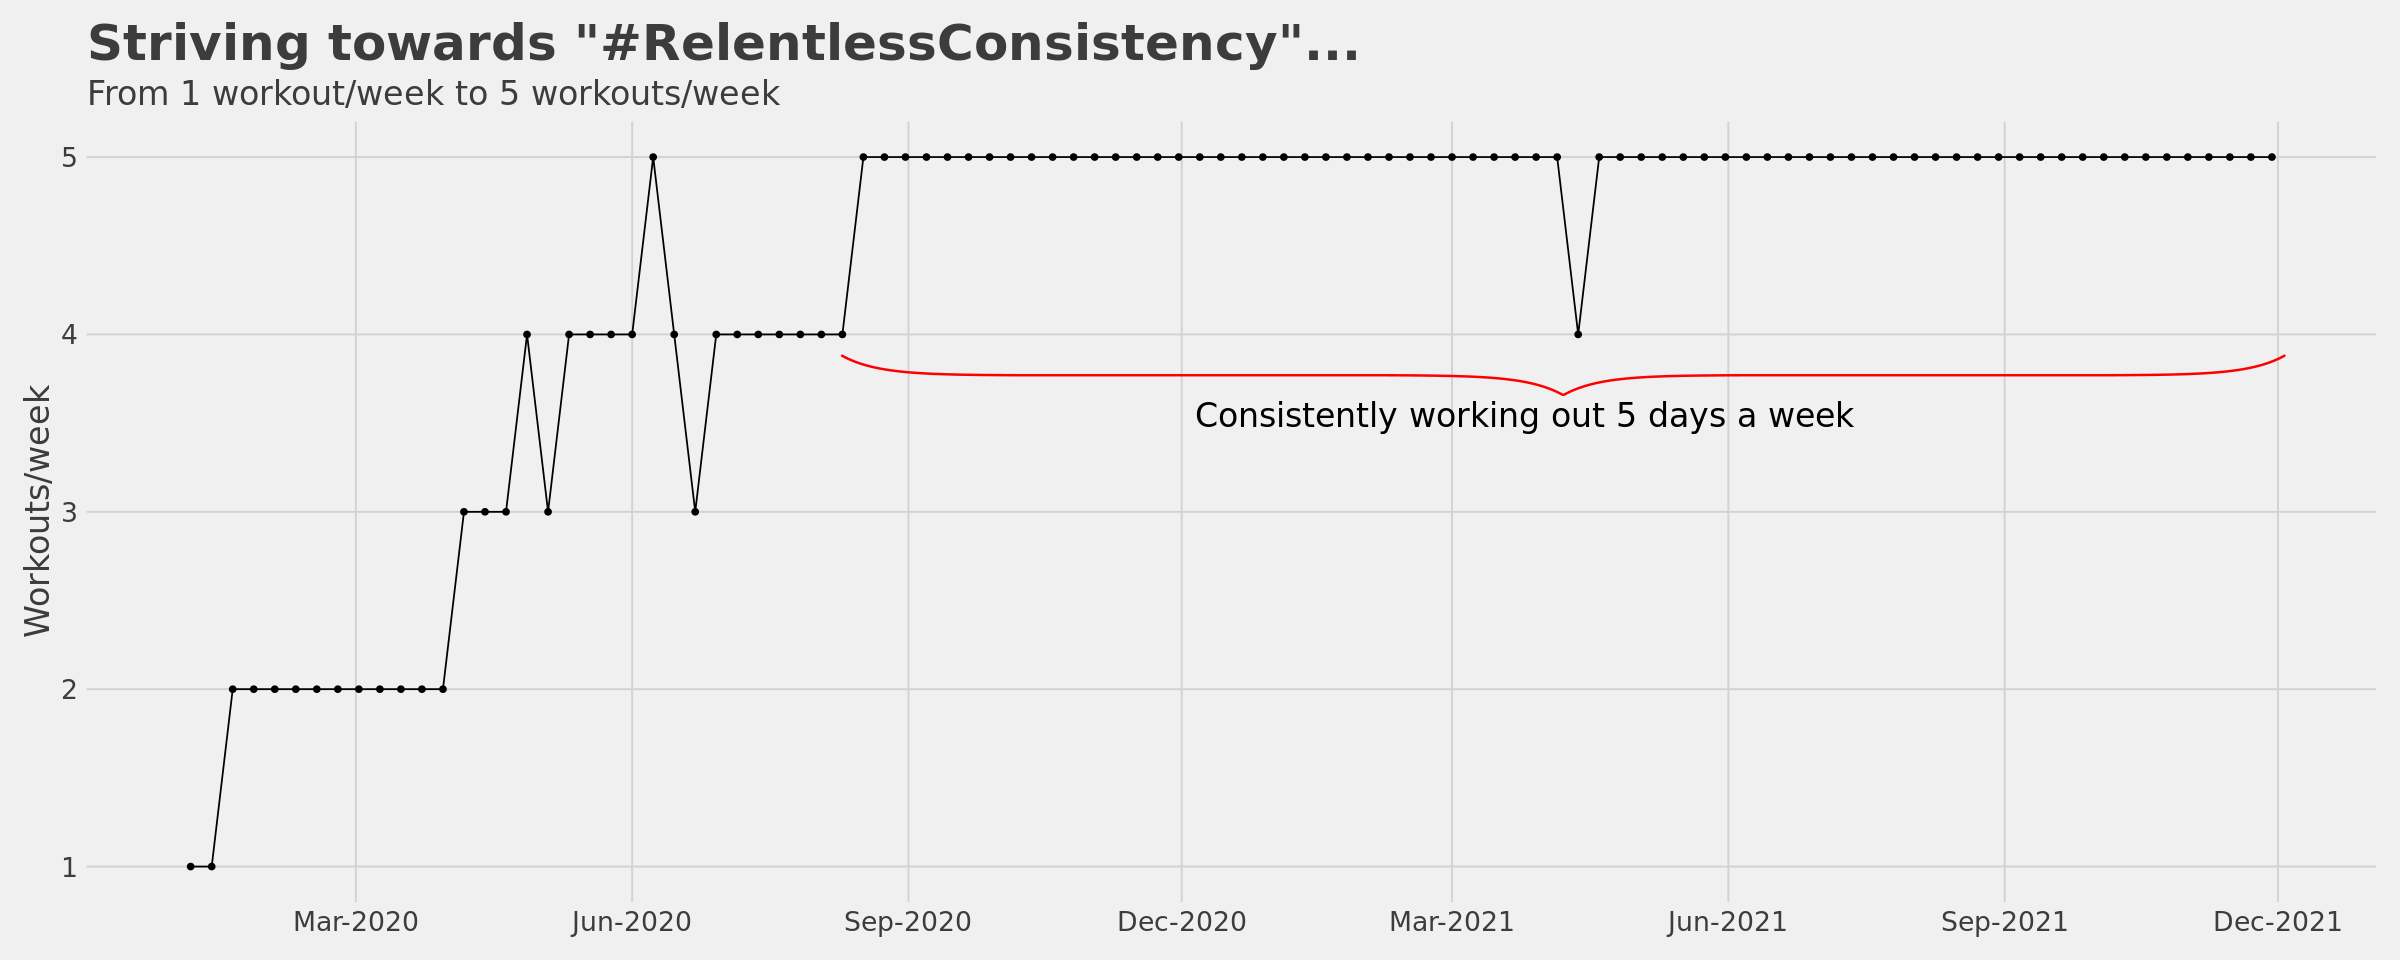

In [46]:
library(grid)
library(pBrackets) 
bracketsGrob <- function(...){
l <- list(...)
e <- new.env()
e$l <- l
  grid:::recordGrob(  {
    do.call(grid.brackets, l)
  }, e)
}

# note that units here are "npc", the only unit (besides physical units) that makes sense
# when annotating the plot panel in ggplot2 (since we have no access to 
# native units)

b1 <- bracketsGrob(0.33, 0.05, 0, 0.05, h=0.05, lwd=2, col="red")
b1 <- bracketsGrob(x2=0.33, y2=0.70, x1=0.96, y1=0.70, h=0.05, lwd=2, col="red")

p2 <- p + 
  annotation_custom(b1)
p2

In [ ]:
df_wt <- read_csv(file.path("data", "Amit.csv"))
head(df_wt)

In [ ]:
df_wt2 <- df_wt %>%
  select(Date, Weight) %>%
  mutate(Weight = as.integer(Weight/10)*10) %>%
  count(Weight) %>%
  mutate(Weight = glue("{Weight}s ({n} days)"))
df_wt2

In [ ]:
library(waffle)
library(ggtext)
text_col <- "#d0cfcd"
light_col <- "#fff1af"
dark_col <- "#585350"
title_col <- "#fc8431"
text_col <- "#d0cfcd"
bg_col <- "#0d101f"
p2_days_counts_as_list <- unlist(df_wt2$n)
names(p2_days_counts_as_list) <- df_wt2$Weight
title <- glue("Journey to losing 61lb in {sum(p2_days_counts_as_list)} days, from {as.integer(max(df_wt$Weight))}lb to {as.integer(min(df_wt$Weight))}lb")
subtitle <- glue("1 box = 1 day")
waffle(
  p2_days_counts_as_list, rows=10, size = 0.5, legend_pos = "bottom",
  #colors = c("#c7d4b6", "#a3aabd", "#a0d0de"),
  title = glue("{title}\n{subtitle}")) + 
theme(text = element_text(size=28)) +
theme(plot.title = element_text(size=28, family="Helvetica Bold")) +
guides(fill = guide_legend(nrow = 1)) +
  ggthemes::scale_fill_tableau(name=NULL) 

In [3]:
df_bw <- read_csv("https://raw.githubusercontent.com/aarora79/biomettracker/master/data/Amit.csv") %>%
  mutate(Date=ymd(Date), Weight=as.numeric(Weight))
head(df_bw)


── Column specification ────────────────────────────────────────────────────────
cols(
  Date = col_character(),
  Weight = col_character(),
  BMI = col_character(),
  `Body Fat` = col_character(),
  `Lean Mass` = col_character(),
  `Muscle Percentage` = col_character(),
  `Water Percentage` = col_character()
)


Warning message:
“ 2 failed to parse.”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Date,Weight,BMI,Body Fat,Lean Mass,Muscle Percentage,Water Percentage
<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
2021-10-09,183.87,27.9,26.1,135.88,39.6,54.0
2021-10-08,186.51,28.3,26.6,136.9,39.4,53.6
2021-10-07,190.26,28.8,27.3,138.32,39.1,53.1
2021-10-06,189.82,28.8,NA,189.82,NA,NA
2021-10-05,189.60,28.7,27.2,138.03,39.1,53.2
2021-10-01,186.29,28.2,26.6,136.74,39.4,53.6


`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



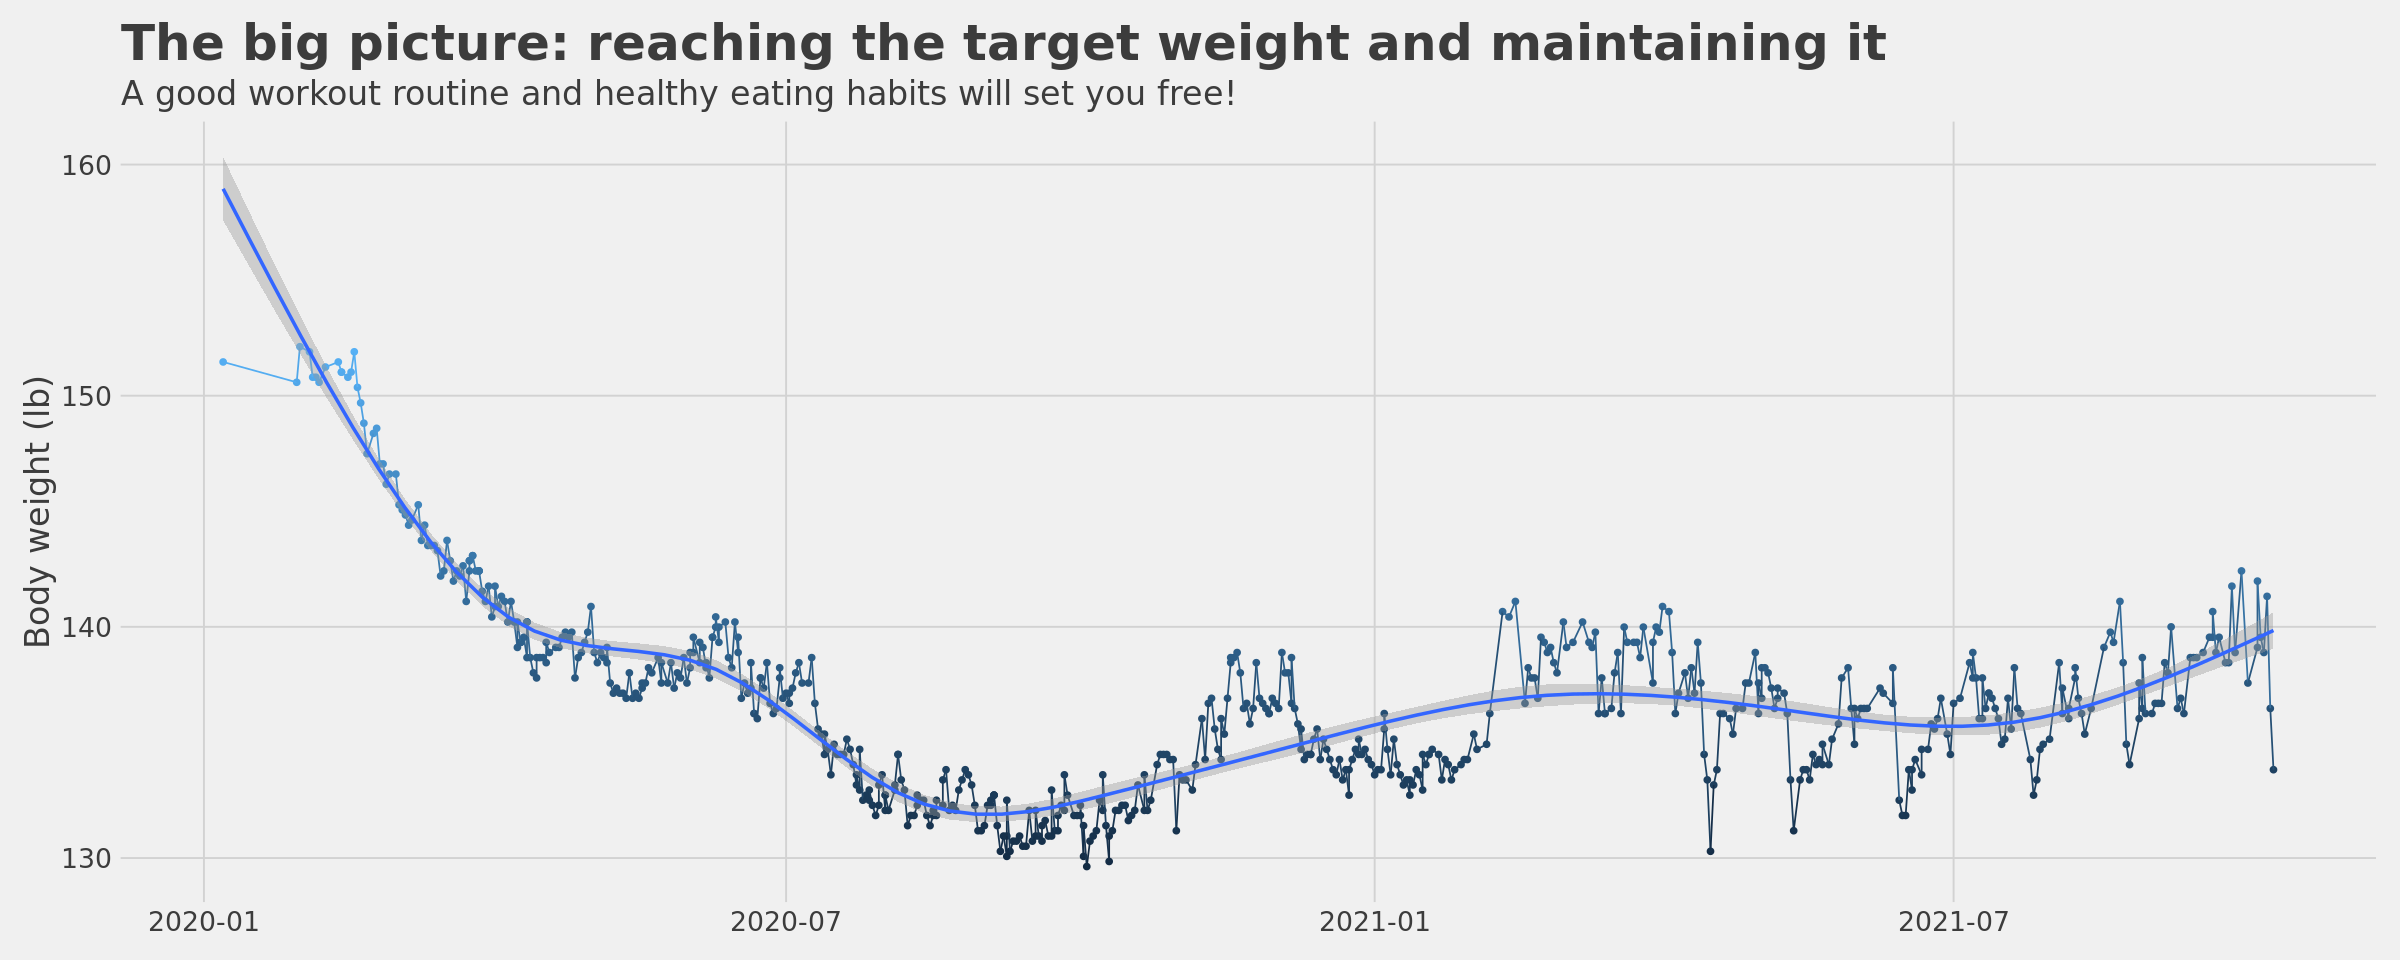

In [36]:
options(repr.plot.width=20, repr.plot.height=8)

title <- "The big picture: reaching the target weight and maintaining it"
subtitle <- "A good workout routine and healthy eating habits will set you free!"

p <- df_bw %>%
  mutate(Weight = as.numeric(Weight)) %>%
  filter(Weight > 100  & Date >= as.Date("2020-1-1")) %>%
  ggplot(aes(x=Date, y=Weight, col=Weight)) +
  geom_point() + 
  geom_line() +
  geom_smooth(method = "gam") +
  #scale_y_continuous(breaks=seq(180, 255, 5)) +
  #scale_y_continuous(breaks=seq(as.integer(min(df_bw$Weight, na.rm=TRUE)), as.integer(max(df_bw$Weight, na.rm=TRUE))+1, 5)) +
  theme_fivethirtyeight() + 
  #scale_color_tableau() +
  labs(title=title,
       subtitle=subtitle) +
  theme(legend.position="none", legend.title = element_blank()) +
  theme(axis.title = element_text(), axis.title.x = element_blank(), text = element_text(size=20)) + 
  xlab("") +
  ylab('Body weight (lb)')
p

In [25]:
start_date <- min(df_bw$Date, na.rm=TRUE)
end_date <- max(df_bw$Date, na.rm=TRUE)
target_wt <- 190
target_wt_achieve_date <- df_bw %>%
  mutate(Weight = as.numeric(Weight)) %>%
  filter(between(Weight, target_wt, target_wt+1)) %>%
  filter(Date == min(Date)) %>%
  pull(Date)
target_wt_achieve_date
target_wt_achieved <- as.numeric(df_bw %>% filter(Date == target_wt_achieve_date) %>% pull(Weight))
wt_loss_phases <- data.frame(name = c("working towards", "maintaining the gains"),
                             start_date = c(start_date, target_wt_achieve_date), 
                             end_date = c(target_wt_achieve_date, end_date),
                             ymin=c(-Inf,185), ymax=c(+Inf,190)
                            )
wt_loss_phases

[1] "2021-04-03"

name,start_date,end_date,ymin,ymax
<chr>,<date>,<date>,<dbl>,<dbl>
working towards,2020-01-16,2021-04-03,-Inf,Inf
maintaining the gains,2021-04-03,2021-10-09,185,190


`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


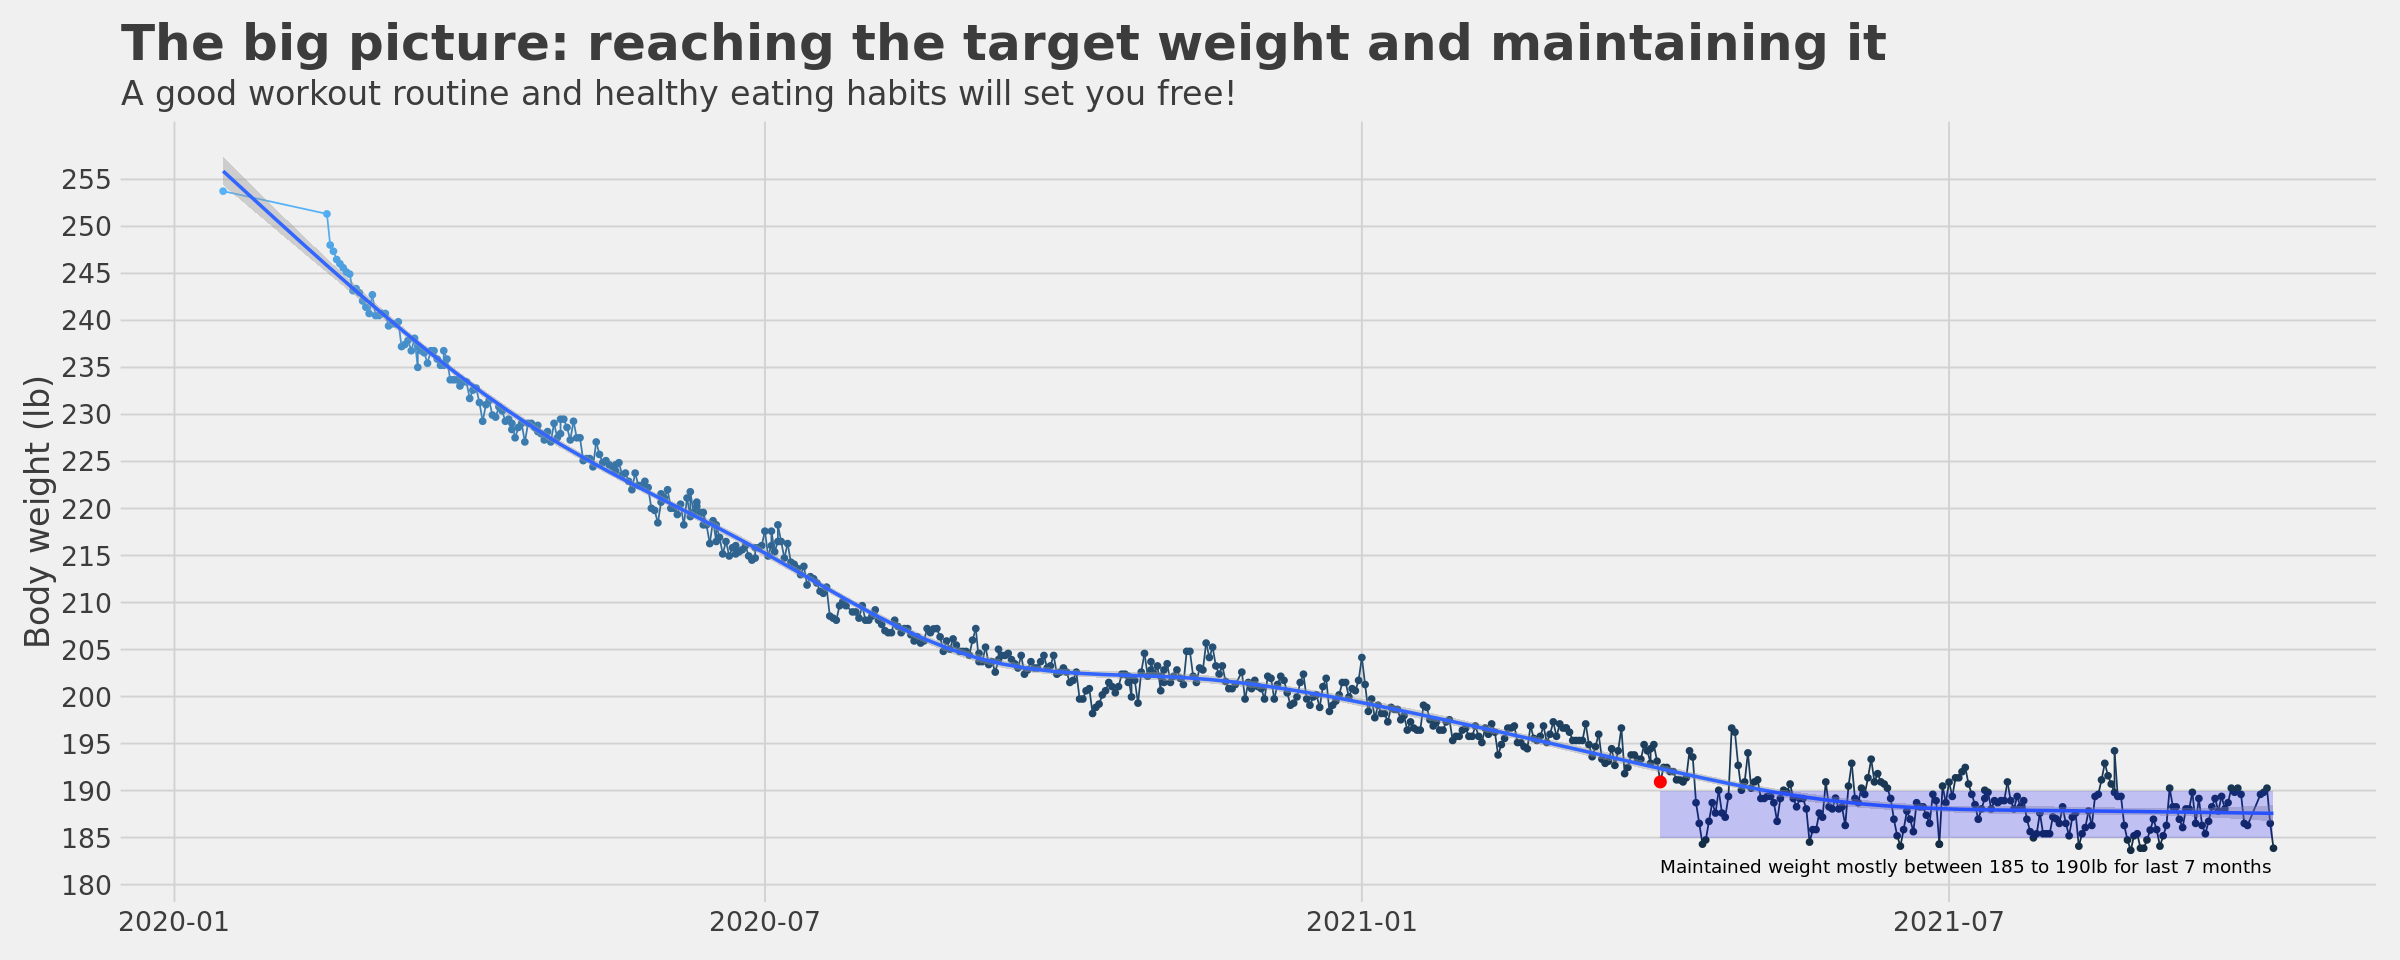

In [31]:
time_since_target_bw <- as.integer(difftime(Sys.Date(), target_wt_achieve_date, units = "weeks")/4)
p + geom_rect(data=wt_loss_phases %>% filter(name =="maintaining the gains"),
              inherit.aes=FALSE,
              aes(xmin=start_date,
                  xmax=end_date, ymin=ymin, ymax=ymax),
                              alpha=0.2, fill="blue") +
    annotate(geom = "point", x = target_wt_achieve_date, y = target_wt_achieved, colour = "red", size = 3) +
    annotate(geom = "text", x = target_wt_achieve_date, y = target_wt_achieved-9, , label = glue("Maintained weight mostly between 185 to 190lb for last {time_since_target_bw} months"), hjust = "left")

In [ ]:
  unemp_table <- read.table(text = "Month        Sample        NYC.Employment     
                     1976-01-01      1              2771                            
                     1976-02-01      2              2770                                       
                     1976-03-01      3              2769                                           
                     1976-04-01      4              2768", header = TRUE, 
                     stringsAsFactors = FALSE)
    unemp_table$Month <- as.Date(unemp_table$Month)


    Reces_table <- read.table(text = "  Start        End
                               1 1980-01-01 1980-07-01
                               2 1981-07-01 1982-11-01
                               3 1990-07-01 1991-03-01
                               4 2001-03-01 2001-11-01
                               5 2007-12-01 2009-06-01", header = TRUE,
                               stringsAsFactors = FALSE)
    Reces_table$Start <- as.Date(Reces_table$Start)
    Reces_table$End <- as.Date(Reces_table$End)

    unemp_graph <- ggplot(data=unemp_table, aes(x=Month,y=NYC.Employment))  + 
      geom_line() + geom_rect(data= Reces_table, inherit.aes = FALSE,
                              aes(xmin=Start, xmax=End, ymin=-Inf, ymax=+Inf), 
                              fill='pink', alpha=0.2)

In [38]:
df_bw <- read_csv("https://raw.githubusercontent.com/aarora79/biomettracker/master/data/Nidhi.csv") %>%
  mutate(Date=ymd(Date), Weight=as.numeric(Weight))
title <- "The big picture: reaching the target weight and maintaining it"
subtitle <- "A good workout routine and healthy eating habits will set you free!"

p <- df_bw %>%
  mutate(Weight = as.numeric(Weight)) %>%
  filter(Weight > 100  & Date >= as.Date("2020-1-1")) %>%
  ggplot(aes(x=Date, y=Weight, col=Weight)) +
  geom_point() + 
  geom_line() +
  geom_smooth(method = "gam") +
  #scale_y_continuous(breaks=seq(180, 255, 5)) +
  #scale_y_continuous(breaks=seq(as.integer(min(df_bw$Weight, na.rm=TRUE)), as.integer(max(df_bw$Weight, na.rm=TRUE))+1, 5)) +
  theme_fivethirtyeight() + 
  #scale_color_tableau() +
  labs(title=title,
       subtitle=subtitle) +
  theme(legend.position="none", legend.title = element_blank()) +
  theme(axis.title = element_text(), axis.title.x = element_blank(), text = element_text(size=20)) + 
  xlab("") +
  ylab('Body weight (lb)')

start_date <- min(df_bw$Date, na.rm=TRUE)
end_date <- max(df_bw$Date, na.rm=TRUE)
target_wt <- 190
target_wt_achieve_date <- df_bw %>%
  mutate(Weight = as.numeric(Weight)) %>%
  filter(between(Weight, target_wt, target_wt+1)) %>%
  filter(Date == min(Date)) %>%
  pull(Date)




── Column specification ────────────────────────────────────────────────────────
cols(
  Date = col_character(),
  Weight = col_character(),
  BMI = col_character(),
  `Body Fat` = col_character(),
  `Lean Mass` = col_character(),
  `Muscle Percentage` = col_character(),
  `Water Percentage` = col_character()
)


Warning message:
“ 3 failed to parse.”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in min.default(structure(numeric(0), class = "Date"), na.rm = FALSE):
“no non-missing arguments to min; returning Inf”


In [44]:
df_bw %>%
  mutate(Weight = as.numeric(Weight)) %>%
  filter(between(Weight, target_wt, target_wt+1)) 

Date,Weight,BMI,Body Fat,Lean Mass,Muscle Percentage,Water Percentage
<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>


In [45]:
df_bw

Date,Weight,BMI,Body Fat,Lean Mass,Muscle Percentage,Water Percentage
<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
2021-10-09,133.82,24.6,28.3,95.95,32.8,52.4
2021-10-08,136.47,25.1,28.8,97.16,32.7,51.9
2021-10-07,141.32,26.0,29.9,99.06,32.4,51.1
2021-10-06,138.89,25.6,29.4,98.06,32.5,51.6
2021-10-05,139.55,25.7,29.5,98.38,32.5,51.4
2021-10-04,139.11,25.6,29.4,98.21,32.5,51.5
2021-10-04,141.98,26.1,30.1,99.24,32.4,51.0
2021-10-01,137.57,25.3,29.1,97.54,32.6,51.7
2021-09-29,142.42,26.2,30.2,99.41,32.3,51.0


In [39]:
target_wt_achieved <- as.numeric(df_bw %>% filter(Date == target_wt_achieve_date) %>% pull(Weight))
wt_loss_phases <- data.frame(name = c("working towards", "maintaining the gains"),
                             start_date = c(start_date, target_wt_achieve_date), 
                             end_date = c(target_wt_achieve_date, end_date),
                             ymin=c(-Inf,185), ymax=c(+Inf,190)
                            )
time_since_target_bw <- as.integer(difftime(Sys.Date(), target_wt_achieve_date, units = "weeks")/4)
p + geom_rect(data=wt_loss_phases %>% filter(name =="maintaining the gains"),
              inherit.aes=FALSE,
              aes(xmin=start_date,
                  xmax=end_date, ymin=ymin, ymax=ymax),
                              alpha=0.2, fill="blue") +
    annotate(geom = "point", x = target_wt_achieve_date, y = target_wt_achieved, colour = "red", size = 3) +
    annotate(geom = "text", x = target_wt_achieve_date, y = target_wt_achieved-9, , label = glue("Maintained weight mostly between 185 to 190lb for last {time_since_target_bw} months"), hjust = "left")

ERROR: Error: Problem with `filter()` input `..1`.
[34mℹ[39m Input `..1` is `Date == target_wt_achieve_date`.
[31m✖[39m Input `..1` must be of size 640 or 1, not size 0.


In [6]:
df_bw %>%
  select(Date, Weight, `Lean Mass`) %>%
  gather(k, v, -Date)

Date,k,v
<date>,<chr>,<chr>
2021-10-09,Weight,183.87
2021-10-08,Weight,186.51
2021-10-07,Weight,190.26
2021-10-06,Weight,189.82
2021-10-05,Weight,189.6
2021-10-01,Weight,186.29
2021-09-30,Weight,186.51
2021-09-29,Weight,189.6
2021-09-28,Weight,190.26
